# Hello World!

In this notebook we show installation and basic usage of **SageNet**. 

## pyG dependencies
pytorch geometric has specefic dependencies which we highly recommend the user to install them following [this](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html 
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html 
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git 

## Install SageNet
The use can clone SageNet  from [GitHub](https://github.com/MarioniLab/sagenet) and install it as follows.

In [ ]:
!git clone https://github.com/MarioniLab/sagenet
%cd sagenet
!pip install .

## Import packages
We use [`anndata`](https://anndata.readthedocs.io/en/latest/) to be compatible with [`scanpy`](https://scanpy.readthedocs.io) and [`squidpy`](https://squidpy.readthedocs.io/en/stable/) for pre- and post-processing steps.



In [ ]:
import sagenet as sg
import scanpy as sc
import squidpy as sq
import anndata as ad
import random
random.seed(10)

## Load datasets

In [ ]:
from copy import copy
adata_r = sg.datasets.seqFISH()
adata_q1 = copy(adata_r)
adata_q2 = sg.datasets.MGA()
sc.pp.subsample(adata_q1, fraction=0.25)
sc.pp.subsample(adata_q2, fraction=0.25)
adata_q = ad.concat([adata_q1, adata_q2], join="inner")
del adata_q1
del adata_q2

In [ ]:
celltype_colours = {
  "Epiblast" : "#635547",
  "Primitive Streak" : "#DABE99",
  "Caudal epiblast" : "#9e6762",
  "PGC" : "#FACB12",
  "Anterior Primitive Streak" : "#c19f70",
  "Notochord" : "#0F4A9C",
  "Def. endoderm" : "#F397C0",
  "Definitive endoderm" : "#F397C0",
  "Gut" : "#EF5A9D",
  "Gut tube" : "#EF5A9D",
  "Nascent mesoderm" : "#C594BF",
  "Mixed mesoderm" : "#DFCDE4",
  "Intermediate mesoderm" : "#139992",
  "Caudal Mesoderm" : "#3F84AA",
  "Paraxial mesoderm" : "#8DB5CE",
  "Somitic mesoderm" : "#005579",
  "Pharyngeal mesoderm" : "#C9EBFB",
  "Splanchnic mesoderm" : "#C9EBFB",
  "Cardiomyocytes" : "#B51D8D",
  "Allantois" : "#532C8A",
  "ExE mesoderm" : "#8870ad",
  "Lateral plate mesoderm" : "#8870ad",
  "Mesenchyme" : "#cc7818",
  "Mixed mesenchymal mesoderm" : "#cc7818",
  "Haematoendothelial progenitors" : "#FBBE92",
  "Endothelium" : "#ff891c",
  "Blood progenitors 1" : "#f9decf",
  "Blood progenitors 2" : "#c9a997",
  "Erythroid1" : "#C72228",
  "Erythroid2" : "#f79083",
  "Erythroid3" : "#EF4E22",
  "Erythroid" : "#f79083",
  "Blood progenitors" : "#f9decf",
  "NMP" : "#8EC792",
  "Rostral neurectoderm" : "#65A83E",
  "Caudal neurectoderm" : "#354E23",
  "Neural crest" : "#C3C388",
  "Forebrain/Midbrain/Hindbrain" : "#647a4f",
  "Spinal cord" : "#CDE088",
  "Surface ectoderm" : "#f7f79e",
  "Visceral endoderm" : "#F6BFCB",
  "ExE endoderm" : "#7F6874",
  "ExE ectoderm" : "#989898",
  "Parietal endoderm" : "#1A1A1A",
  "Unknown" : "#FFFFFF",
  "Low quality" : "#e6e6e6",
  # somitic and paraxial types
  # colour from T chimera paper Guibentif et al Developmental Cell 2021
  "Cranial mesoderm" : "#77441B",
  "Anterior somitic tissues" : "#F90026",
  "Sclerotome" : "#A10037",
  "Dermomyotome" : "#DA5921",
  "Posterior somitic tissues" : "#E1C239",
  "Presomitic mesoderm" : "#9DD84A"
}

## Preprocess the reference dataset

In [ ]:
from sagenet.utils import glasso
import numpy as np
glasso(adata_r, [0.5, 0.75, 1])
adata_r.obsm['spatial'] = np.array(adata_r.obs[['x','y']])
sq.gr.spatial_neighbors(adata_r, coord_type="generic")
sc.tl.leiden(adata_r, resolution=.01, random_state=0, key_added='leiden_0.01', adjacency=adata_r.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r, resolution=.05, random_state=0, key_added='leiden_0.05', adjacency=adata_r.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r, resolution=.1, random_state=0, key_added='leiden_0.1', adjacency=adata_r.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r, resolution=.5, random_state=0, key_added='leiden_0.5', adjacency=adata_r.obsp["spatial_connectivities"])
sc.tl.leiden(adata_r, resolution=1, random_state=0, key_added='leiden_1', adjacency=adata_r.obsp["spatial_connectivities"])

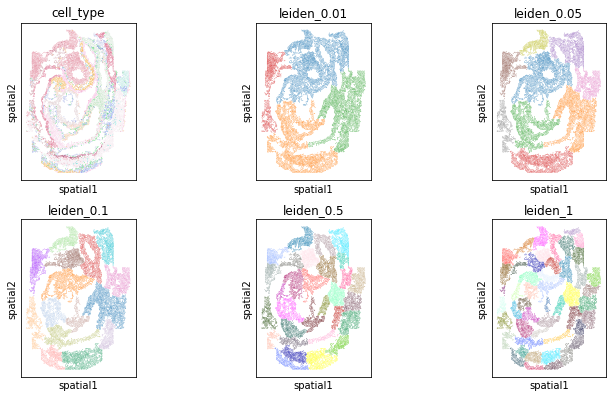

In [ ]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (3, 3)}):
  sc.pl.spatial(adata_r, color=['cell_type', 'leiden_0.01', 'leiden_0.05', 'leiden_0.1', 'leiden_0.5', 'leiden_1'], ncols=3, spot_size=0.03, legend_loc=None)

## Check for GPU availibility

In [ ]:
import torch
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)
print(device)

cuda:0


## Define the `sagenet` object

In [ ]:
sg_obj = sg.sage.sage(device=device)

## Train on the reference dataset

In [ ]:
sg_obj.add_ref(adata_r, comm_columns=['leiden_0.01', 'leiden_0.05', 'leiden_0.1', 'leiden_0.5', 'leiden_1'], tag='seqFISH_ref', epochs=20, verbose = False)

## Spatially informative genes

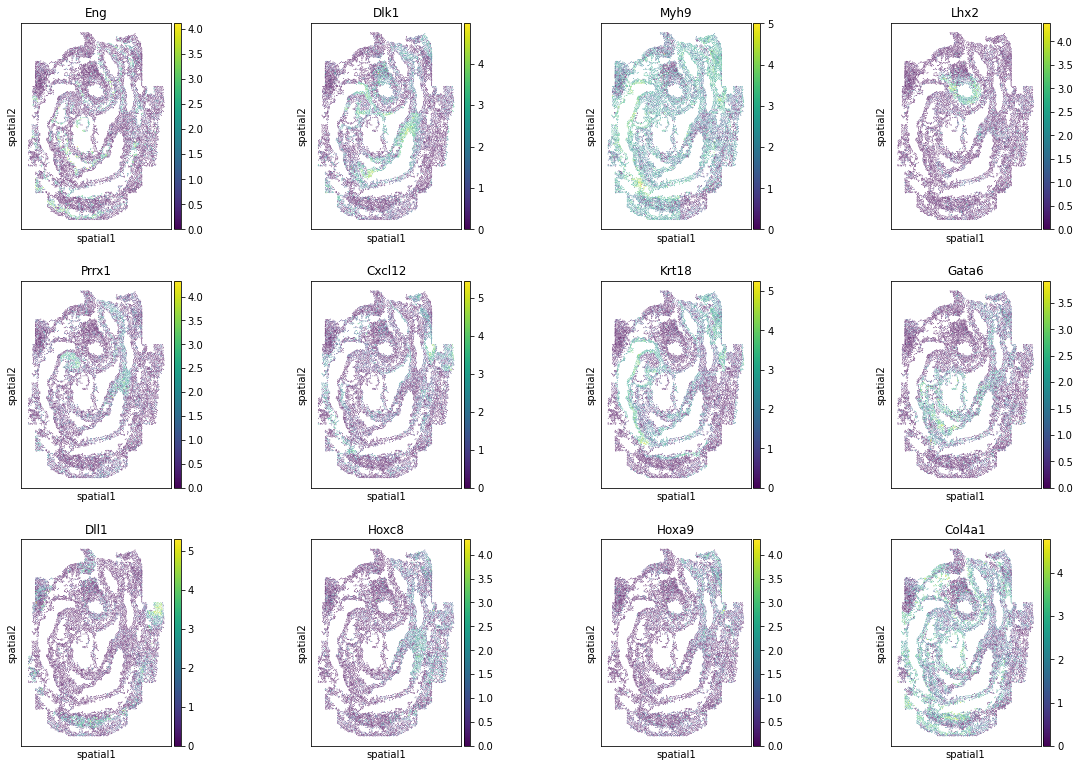

In [ ]:
ind = np.argsort(-adata_r.var['seqFISH_ref_entropy'])[0:12]
with rc_context({'figure.figsize': (4, 4)}):
  sc.pl.spatial(adata_r, color=list(adata_r.var_names[ind]), ncols=4, spot_size=0.03, legend_loc=None)

## Save the trained model

In [ ]:
!mkdir models
!mkdir models/seqFISH_ref
sg_obj.save_model_as_folder('models/seqFISH_ref')

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘models/seqFISH_ref’: File exists


## Map the query dataset to space

In [ ]:
sg_obj.map_query(adata_q)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Compute UMAP of the embedded cells

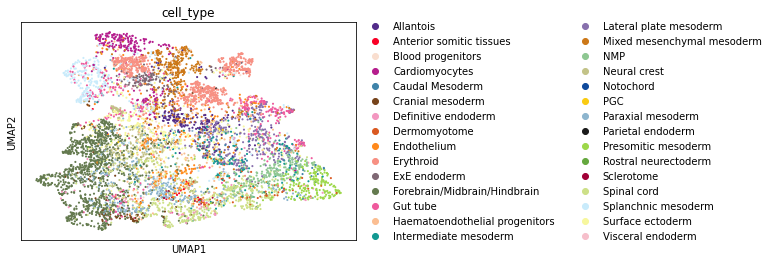

In [ ]:
import anndata
dist_adata = anndata.AnnData(adata_q.obsm['dist_map'], obs = adata_q.obs)
knn_indices, knn_dists, forest = sc.neighbors.compute_neighbors_umap(dist_adata.X, n_neighbors=50, metric='precomputed')
dist_adata.obsp['distances'], dist_adata.obsp['connectivities'] = sc.neighbors._compute_connectivities_umap(
    knn_indices,
    knn_dists,
    dist_adata.shape[0],
    50, # change to neighbors you plan to use
)
sc.pp.neighbors(dist_adata, metric='precomputed', use_rep='X')
sc.tl.umap(dist_adata)
sc.pl.umap(dist_adata, color='cell_type', palette=celltype_colours, save='eli.pdf')